**Intro to Preprocessing and Feature Extraction** | CortexCodec

EEG Motor Movement/Imagery Dataset (Sept. 9, 2009, midnight)

A set of 64-channel EEGs from subjects who performed a series of motor/imagery tasks has been contributed to PhysioNet by the developers of the BCI2000 instrumentation system for brain-computer interface research.

When using this resource, please cite the original publication:
Schalk, G., McFarland, D.J., Hinterberger, T., Birbaumer, N., Wolpaw, J.R. BCI2000: A General-Purpose Brain-Computer Interface (BCI) System. IEEE Transactions on Biomedical Engineering 51(6):1034-1043, 2004.


Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220. RRID:SCR_007345.

https://physionet.org/content/eegmmidb/1.0.0/S001/#files-panel

In [ ]:
# install python packages using pip (standard package installer for Python)
# you are allowed to add more if you think it will be useful for your process

!pip -q install matplotlib
!pip -q install scipy
!pip -q install mne
!pip -q install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 101.8 MB/s eta 0:00:00


In [ ]:
# import required packages (fill in the blanks!)
# you may not use all of these
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import pywt
import mne
import numpy as np


The most important part of working with data is making sure you have data to work with. To load .edf files (or pretty much any EEG file) first download the data and then import the file to your Drive. Then, we want to allow the Colab to access our Drive so that we can choose the specific file to work with.

I recommend making a specific folder in your drive for CC files so that it is easier to navigate. After mounting your data, you should see a file path, specifically linked to your drive, appear on the left under the files tab.


https://physionet.org/content/eegmmidb/1.0.0/S001/#files-panel
This is the dataset we'll be using! Please navigate through this, download S001R01.edf, and import that file to your Google Drive. Then, copy the file path from your files tab on Colab and paste that where it says 'file_path = ???'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from the files tab, copy your specific file path
file_path = '/content/drive/MyDrive/Files_CortexCodec/S001R01.edf'

https://mne.tools/stable/auto_tutorials/intro/10_overview.html#tut-overview

Here's the cheatsheet for a lot of the work we'll be doing. **Please** try to do this work on your own! But if you find yourself struggling you can reference this page.

Extracting EDF parameters from /content/drive/MyDrive/Files_CortexCodec/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Using matplotlib as 2D backend.


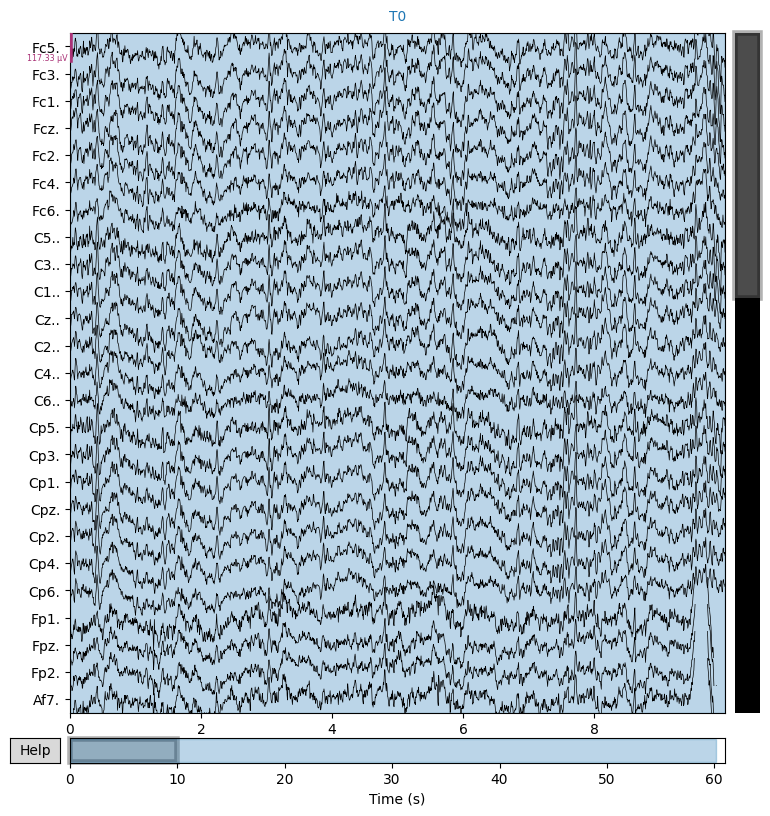

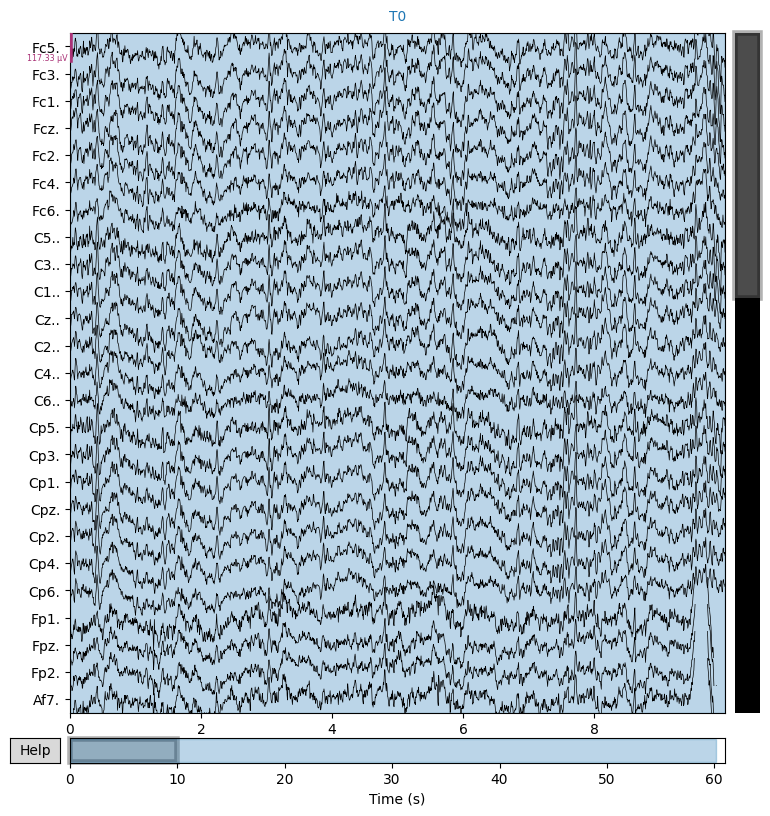

In [ ]:
# lets get a visualization of our raw data! reference https://mne.tools/stable/api/reading_raw_data.html to fill in the blanks
# we set preload to true to save the data to our memory. you may also use raw.load_data() instead but both are essentially the same for our purposes
raw = mne.io.read_raw(file_path, preload=True)

# raw.plot will be how we plot our raw data, its useful for understanding if the file we're using is suitable for anaylsis
# please plot the first 15-25 channels of our data (but you can play around with your n_channels value)

raw.plot(n_channels = 25, scalings='auto', title='Raw EEG Data Visualization')

In [ ]:
# lets learn a little bit about the data we're working with

info = raw.info
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


In [ ]:
fs = 160 # you can also find this with raw.info['sfreq']!
#but for the purposes of this assignment reference your data from raw.info to find what the sampling freq. of our data is

# how many channels are in our data? 64
# what is the original highpass and lowpass frequencies? 0Hz and 80Hz

Now that we know a little more about the data we're working with, lets start cleaning it. For our purposes, we will be trying to use ICA and PCA (which I will teach you guys how to do manually in another session as its a little more complicated than ICA).

For now, lets look at bandpass filtering. A bandpass filter allows a specific range of frequencies to pass through, removing both low frequency and high frequency articfacts. Its usually pretty effective to have your first step of preprocessing include a bandpass filter, just because its a simple way to remove prominent artifacts.

https://mne.tools/stable/generated/mne.io.Raw.html

In [ ]:
# apply a bandpass filter from what you think would be the best for our data based on your research!
# feel free to play around with this but make sure you reset the raw data each time so you're not filtering already filtered data
raw.filter(l_freq=1, h_freq=40)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)



<RawEDF | S001R01.edf, 64 x 9760 (61.0 s), ~4.8 MiB, data loaded>

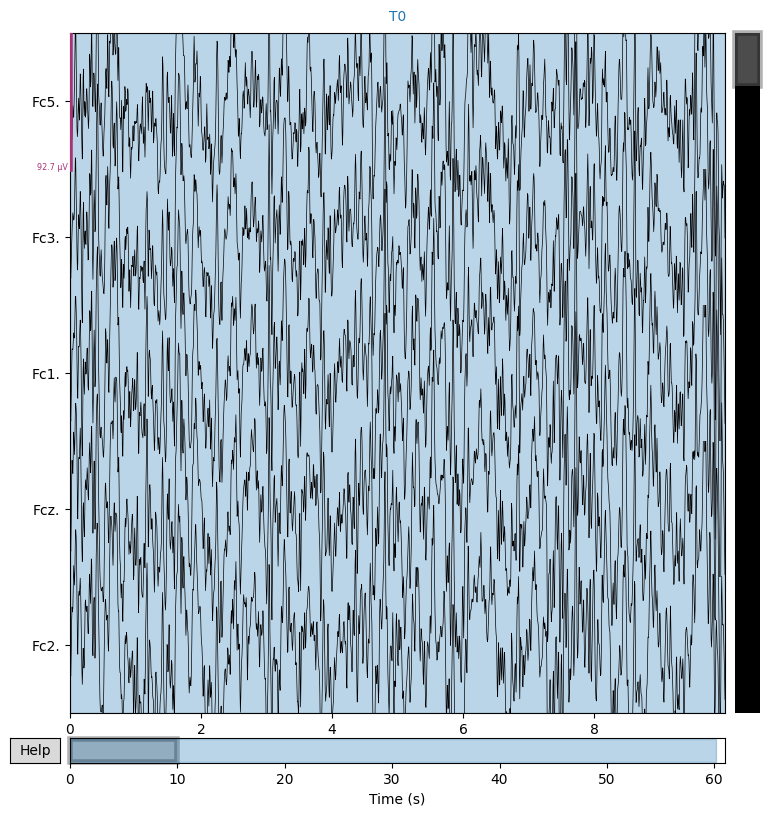

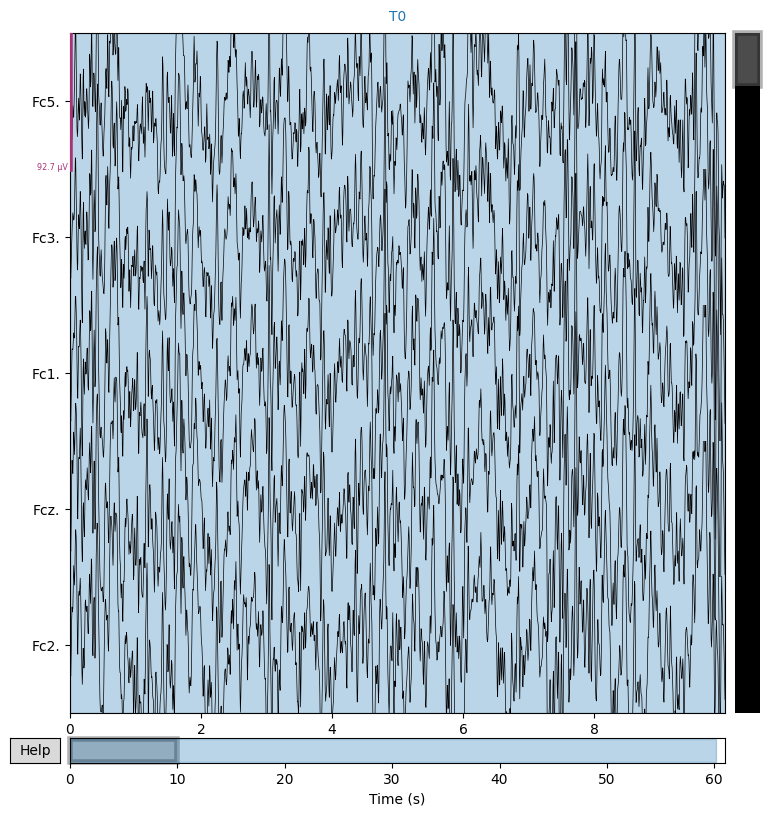

In [ ]:
# please do 5 channels this time :)
raw.plot(n_channels = 5, scalings='auto', title='Filtered EEG Data Visualization')

🤯 Our visualization looks a little crazier than our raw data. But, if we're cleaning our signal, why does it seem to be "worse"? This is due to the fact that a bandpass filter can make the amplitude of our signals *appear* to change by removing competing frequencies. When you apply a bandpass filter, you can remove frequency components that may be canceling out or obscuring our true signal. That's why our resulting data has a higher peak amplitude: because the targeted frequency is no longer being masked.

We also zoomed in on our data, only looking at 5 channels now.

In [ ]:
# now lets move on to cleaning an individual channel. its definitely possible to clean more than one channel at once, but for the purpose of this assignment:
# determine what the first channel in this dataset is called: Fc5.

print(raw.ch_names)

['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..']


In [ ]:
# this is an easier way of figuring out what you did in the last cell! if its our first channel, what shoud go in our index slot?
channel_name = raw.ch_names[0]
print(channel_name)

Fc5.


We'll move on to our application of ICA now. This will be our primary form of preprocessing data! It is the most common preprocessing tenchique used in functional neural data anaylsis.

ICA splits the EEG signals into independent components using information theory methods (statistical analysis of subcomponents). Grace will talk about this during our meeting!

In [ ]:
# time for ICA! https://mne.tools/stable/generated/mne.preprocessing.ICA.html
from mne.preprocessing import ICA

ica = mne.preprocessing.ICA(n_components=15, random_state=97, max_iter=800)


# lets fit our ICA model to our raw data
ica.fit(raw)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.1s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=800
Fit,36 iterations on raw data (9760 samples)
ICA components,15
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=15, n_times=9760
    Range : 0 ... 9759 =      0.000 ...    60.994 secs
Ready.


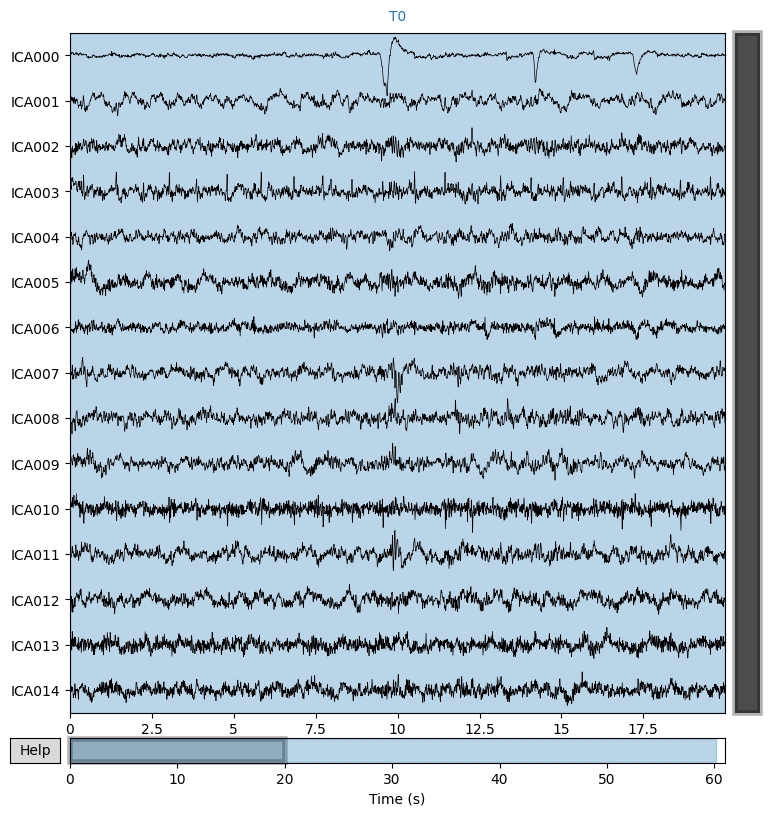

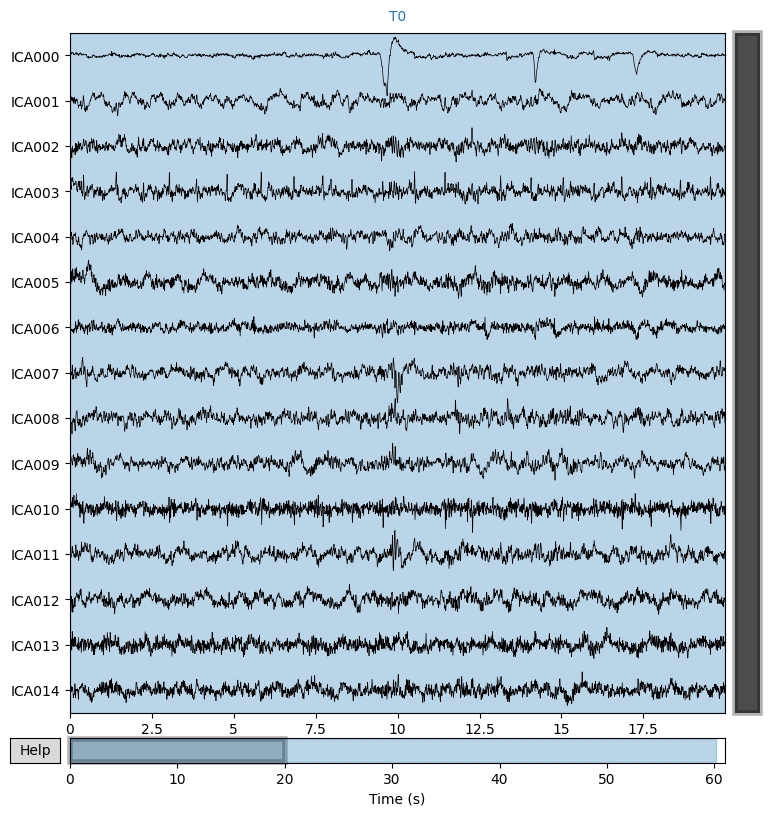

In [ ]:
ica.plot_sources(raw)

In [ ]:
ica.exclude = [0, 7]

In [ ]:
# now that we've fitted the data to our analysis model, lets apply it!

raw_clean = ica.apply(raw.copy())

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


In [ ]:
# please extract data for plotting purposes (reference the mne.raw link if you're stuck)
# we'll be comparing the first channel of our dataset, so please put the first array index in the []

data_raw = raw.get_data()[0]
data_clean = raw_clean.get_data()[0]

In [ ]:
time = np.arange(len(data_raw)) / fs # this helps creates an array of timestamps corresponding to a sampled signal
# we must generate a time axis to plot signal processing
# if you have questions on how this line of code works, talk to me at office hours this week! but for now don't worry too much about it, it'll look the same for most of our work

In [ ]:
print("Analyzing channel: " +  "Fc5.")
print("Sampling rate: " + " 160.0" + "Hz")

Analyzing channel: Fc5.
Sampling rate:  160.0Hz


In [ ]:
# reset raw to its rawest form, as we previously applied ICA and a bandpass filter
raw = mne.io.read_raw_edf(file_path, preload=True)
data_raw = raw.get_data()[0]

Extracting EDF parameters from /content/drive/MyDrive/Files_CortexCodec/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...


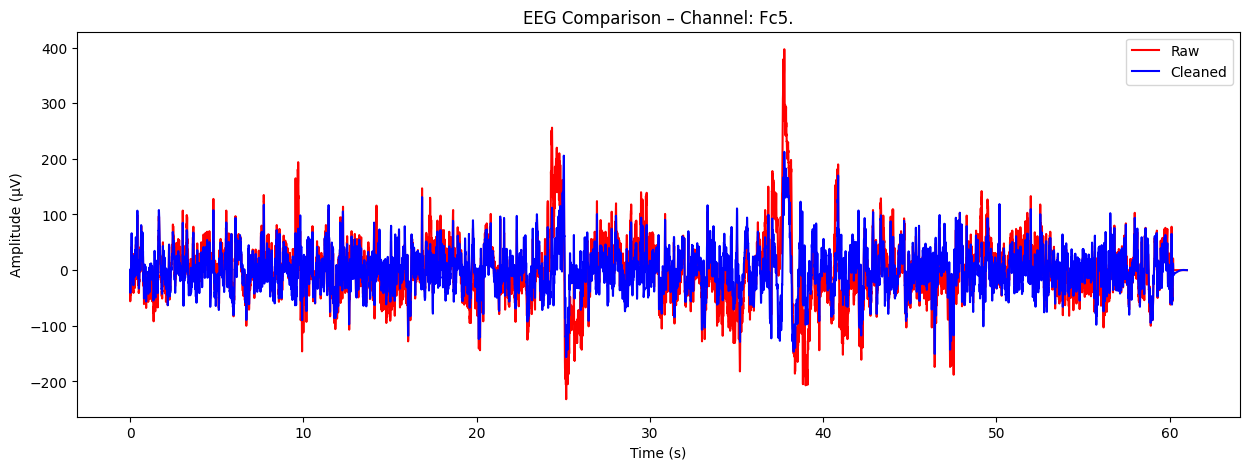

In [ ]:
# lets plot our cleaned data against our raw data so we can see what all our work has done so far
plt.figure(figsize=(15, 5))
# scale up data, as MNE plots in microvolts instead of volts (which is the form our data is in) --> what power of 10 do we multiply our data by?
# notice that this is in the form of (x, y, label, color) this should help you later
plt.plot(time, data_raw * 1e6, label='Raw', color='red')
plt.plot(time, data_clean * 1e6, label='Cleaned', color='blue')

# these should be your standard plotting procedures! always include a title, axis labels, and a legend at the very least. you can copy this later on
plt.title('EEG Comparison – Channel: ' + str("Fc5."))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.legend()


plt.show()

Congratulations!! I hope that this demonstration of bandpass and ICA gives you a visual demonstration of why these procedures are so crucial when working with EEG data.

Lets move on to some visualizations of feature extraction with our data. Now that we have clean data, we can extract certain features to train our model with. I'm sure that you guys are more than familiar with why we do FE so I'll save you the additional lecture. Our two main forms that we'll be focusing on are discrete wavelet transform (DWT) and short-time fourier transform (STFT). Grace will give a demonstration in class about why we choose to use these two forms to analyze data.

This section will be dedicated to visualizing feature extraction. As we approach model training, I can teach you all how to properly use and label the features we find, but for now, lets stick to visualization to reduce the complexity of this assignment.

In [ ]:
wavelet = 'db4'
# db4 is the most popular and well-received wavelet for wavelet transform, and it designs the shape of the wavelet used to transform the data
# it stands for the Daubechies wavelets, and the “4” means it uses 4 coefficients in its filter
# feel free to learn more about why this wavelet is the standard, but its not super important for you to know :)

decomp_level = 2 # do you remember when we talked about decomposition levels? this is the max decomposition level used in our data.
# feel free to reference our past lit reviews if you forgot or want more information on what a DL is!
# set this to a respectable Dlevel based on our sampling frequency! (Hint: D1-D2 might be the most suited for our data)

coeffs = pywt.wavedec(data_clean, wavelet, decomp_level)
# this line is where the actual DWT application happens
# coeffs represents a list of approximation + detail coefficients, which we learned about when we talked about DWT. i believe i also linked a video that talks about DWT coeffs if you're still curious
# for all levels based on our *clean* data, our wavelet form, and our DL (in that order)! fill in the blanks


In [ ]:
#we need to combine our list of arrays into a matrix for analysis now
#first we need to determine how long our matrix should be first, so lets cycle through coeffs and determine the maximum length
arr_len = max(len(c) for c in coeffs)
#this line then pads all of the shorter arrays with 0's so that everything is the same length as the longest one
pad_coeffs = [np.pad(c, (0, arr_len - len(c))) for c in coeffs]
coeff_matrix = np.array(pad_coeffs)

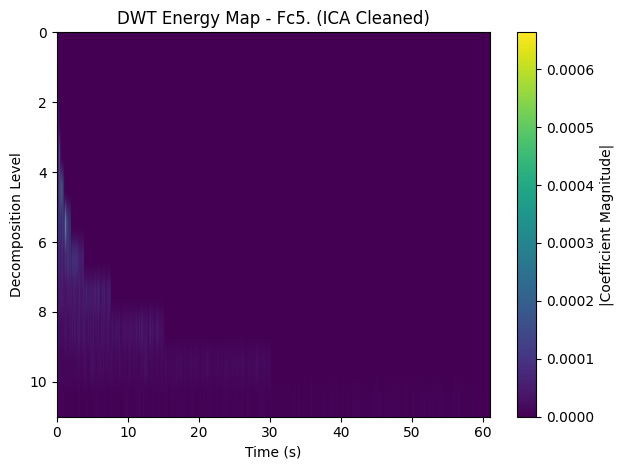

In [ ]:
plt.imshow(np.abs(coeff_matrix), aspect='auto',
           extent=[0, len(data_clean)/fs, len(coeffs), 0])
plt.colorbar(label='|Coefficient Magnitude|')
plt.title(f"DWT Energy Map - {channel_name} (ICA Cleaned)")
plt.xlabel("Time (s)")
plt.ylabel("Decomposition Level")
plt.tight_layout()
plt.show()


Congratulations! You plotted a DWT scalogram based on data you cleaned! So proud of yall.

Take a look at the graph and see if you can visually identify any meaningful features. Write down at least 2 time stamps.

Lets move on to STFT now. Both FE methods are good, and it honestly depends on the data you're using! I think Grace will talk about when/where to use DWT vs. STFT.

In [ ]:
# this line of code is deceptively simple but i will provide some information on how it works
f, t, psd = spectrogram(data_clean, 160, nperseg=256, noverlap=128)
# set this with a 50% overlap

The spectrogram function from scipy returns 3 outputs, frequency (f), time (t), and power spectral density (psd). It computes how the signal’s frequency content changes over time by splitting the signal into short windows and taking the FFT of each window.

Refresh yourself on what STFT and FFT are and how they work!

It'll take 4 parameters from us, data, sample freq, number of samples per window (segment length), and number of samples that overlap between windows
nperseg determines the time vs. frequency resolution:

a large nperseg → better frequency resolution, worse time resolution
a small nperseg → better time resolution, worse frequency resolution

Its all a big tradeoff, but 128-512 is usually the norm for 100-200 Hz sampling frequencies. Make sure that your nperseg is a POWER OF 2 as we are working with FFT.

Calculate overlap with noverlap/nperseg = overlap! This just ensures that we don't lose much data between windows.

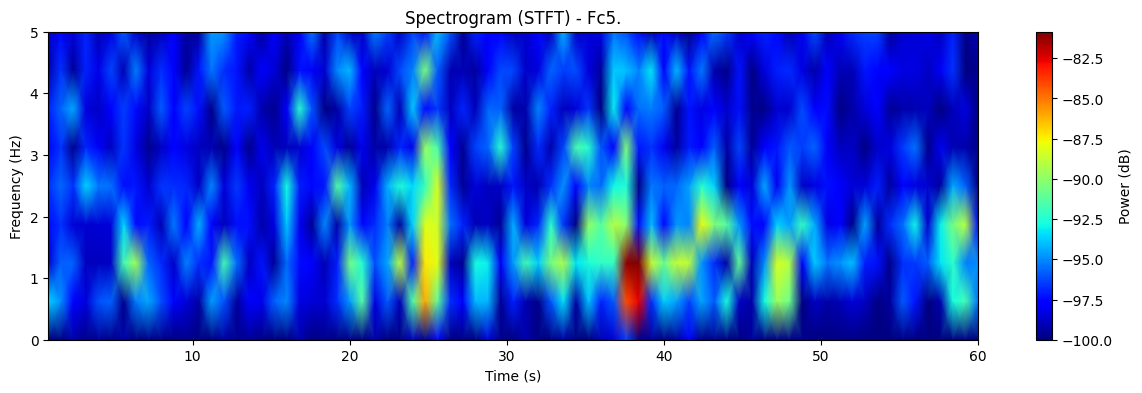

In [ ]:

# this is just plotting our spectrogram
# a spectrogram is the visual representation of STFT, which analyzes how a signal's frequency content changes over time
# FREQUENCY OVER TIME figure out which is x axis and which is y and fill in the blanks above
# the 3rd paramater just scales our psd data appropriately, and the other two are just design parameters that i filled in for you


plt.figure(figsize=(15, 4))
plt.pcolormesh(t, f, 10 * np.log10(psd + 1e-10), shading='gouraud', cmap='jet')
plt.title(f"Spectrogram (STFT) - {channel_name}")
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.ylim(0, 5)  # focus on EEG
plt.colorbar(label='Power (dB)')

plt.show()

This concludes our first homework assignment. I hope that it went well and you learned more about standard computational analysis and in respect to EEG data! I know that this data wasn't emotion-specific, but a lot of the work that we'll be doing with emotion data is incredibly similar to this baseline approach. Feel free to download more data from OpenNeuro and experiment with the libraries we used today.

I'm excited that we'll be moving on to a more technical approach, but remember all of the lit review we've done this far. As you can tell from a lot of my comments, your understanding of the code relies heavily on your understanding of the methodology we've studied.

Thank you for working so hard on this, and feel free to reach out with ANY QUESTIONS no matter how simple. Even if you want us to explain what print(raw) means, we will. Office hours are hosted by Grace and I weekly with the goal of furthering your understanding and answering any questions, so feel free to stop by. Next week, we'll be working on classification charting, which may be a little more complicated, so I encourage you to refresh your memory on what SVM and KNN analysis is.

Have an amazing week/weekend, and thank you for completing this assignment!